# Презентация Дипломного проекта специализации "Machine Learning and Data Analysis" (Coursera)

## Анализ и предсказание временных рядов

In [ ]:
# Проект основан на обработке сырых данных о поездках Жёлтого такси в Нью-Йорке
# в первой половине 2016 года, скачанных с правительственного сайта:
# www.nyc.gov/html/tlc/html/about/trip_record_data.shtml 

##### ЗАДАЧА: Построить предсказание поездок в июне 2016 г., обучаясь на данных о поездках в январе - мае 2016 г.

In [ ]:
# Работа над проектом заняла около 2-х месяцев.
# В ходе работы был осуществлен следующий анализ:
# 1. Обработка сырых данных (чистка данных, форматирование, аггрегация, 
#    разбиение Нью-Йорка на регионы, визуализация, фильтрация и др.)
# 2. Применение модели SARIMAX для предсказания временных рядов
# 3. Проведение кластеризации географических зон
# 4. Выбор признаков для применение альтернативной модели - регрессии
# 5. Оптимизация регрессионной модели путём добавления новых признаков

In [ ]:
# Ввиду очень большого объёма кода и проведенного выше анализа,
# был разработан данный презентационный код, 
# демонстрирующий конечный результат работы над проектом 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import holoviews as hv
#in Terminal:  conda install -c pyviz holoviews bokeh
#from holoviews import opts
import datetime
import warnings
#hv.extension('bokeh', 'matplotlib')
import folium
from folium.plugins import HeatMap
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display, HTML

from IPython.display import Image

In [2]:
# грузим данные о поездках из 102-го региона
data = pd.read_csv('Data/DataTrips102.csv', sep=',')
data['time'] = pd.to_datetime(data['time'])
# оставляем только июньские данные
data = data[data.time >= datetime.datetime(2016, 6, 1)]
# ставим время индексом
data.set_index('time',inplace=True)
data.tail(2)

,zone,num_trips
time,,
2016-06-30 23:00:00,2119,119.0
2016-06-30 23:00:00,2168,0.0


In [3]:
# загружаем сделанные предсказания наилучшей модели - оптимизированной регрессионной
dataPred = pd.read_csv('Data/pred_table.csv', sep=',')
dataPred.drop('Unnamed: 0', axis=1, inplace=True)
dataPred['time'] = pd.to_datetime(dataPred['time'])
dataPred.head(2)

,time,region,y1,y2,y3,y4,y5,y6
0,2016-05-31 23:00:00,1075,23.862931,10.386250,-4.938699,-10.669369,-6.297226,3.525538
1,2016-06-01 00:00:00,1075,9.513744,-2.924906,-8.022060,-0.565592,9.133963,24.968098


In [4]:
# список регионов
reg_list = np.unique(list(data.zone))
# вводим объект - карту Нью-Йорка с привязкой к координатам города ниже
latt_ESB = 40.74778
long_ESB = -73.98583
map = folium.Map(location=[latt_ESB, long_ESB], zoom_start=12)

### 1. Визуализация реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени

In [6]:
# загружаем разбиение города на 50х50 = 2500 зон
regions = pd.read_csv('Data/regions.csv', sep=';')
# оставляем лишь рассматриваемые 102 региона, 
# из которых осуществляется в среднем не менее 5 поездок в час  
def regenv(reg, reg_list):
    if reg in reg_list:
        return True
    else:
        return False
regions['regs102'] = regions.apply(lambda x: regenv(x['region'], reg_list), axis=1)
regions = regions[regions.regs102 == True]
regions.drop('regs102', axis=1, inplace=True)
# вычисляем центр каждого региона
def cent(a,b):
    return (a+b)/2
regions['latt'] = regions.apply(lambda x: cent(x['south'], x['north']), axis=1)
regions['long'] = regions.apply(lambda x: cent(x['west'], x['east']), axis=1)
regions.drop(['west','east','south','north'], axis=1, inplace=True)
regions.head(2)

,region,latt,long
1074,1075,40.701631,-74.016691
1075,1076,40.710019,-74.016691


In [7]:
# Создаём ф-цию отрисовки реальных и предсказанных поездок, где:
# day - выбираемый день месяца (июня)
# hour - выбираемый час выбранного дня месяца
# predNum - скольки-часовое предсказание выбираем (от 1 до 6)
def Visualization(day, hour, predNum):
    time = datetime.datetime(2016, 6, day, hour)
    # формируем столбец поездок в выбранное время из всех 102-х регионов
    subdata = list(data[data.index == time].num_trips)
    map_real = folium.Map(location=[latt_ESB, long_ESB], zoom_start=10)
    map_real.add_child(HeatMap(zip(regions['latt'].values, regions['long'].values, subdata), radius = 10))
    map_real.save('trips_real.html')
    # формируем столбец предсказанных поездок в выбранное время из всех 102-х регионов, 
    # в зав-ти от временного лага предсказания
    dT = datetime.timedelta(hours=1)
    if predNum == 1:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y1)
    if predNum == 2:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y2)
    if predNum == 3:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y3)
    if predNum == 4:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y4)
    if predNum == 5:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y5)
    if predNum == 6:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y6)
    map_pred = folium.Map(location=[latt_ESB, long_ESB], zoom_start=10)
    map_pred.add_child(HeatMap(zip(regions['latt'].values, regions['long'].values, subdata_pred), radius = 10))
    map_pred.save('trips_pred.html')
    
    real_title = u'Реальные данные:'
    pred_title = u'Предсказанные на ' + str(predNum) + ' час(ов):'
    # отображаем нарисрванные выше карты в html-структуре
    disp = u'Дата: {0:0>2}.06.2016 Время: {1:0>2}:00:00'.format(day, hour)
    htmlText = ''
    htmlText = htmlText + '<table>'
    htmlText = htmlText + '<tr><td colspan="2" style="text-align:center;"><h3>' + disp + '</h3></td></tr>'
    htmlText = htmlText + '<tr><td><h3 style="text-align:center;">' + real_title + '</h3></td><td><h3 style="text-align:center;">' + pred_title + '</h3></td></tr>'
    htmlText = htmlText + '<tr><td><iframe src="trips_real.html" width="400" height="300"></iframe></td>'
    htmlText = htmlText + '<td><iframe src="trips_pred.html" width="400" height="300"></iframe></td></tr>'
    htmlText = htmlText + '</table>'
   
    display(HTML(htmlText))

In [8]:
# вырисовываем карты реальных и предсказываемых поездок с возможностью пользовательского выбора параметров
InteractData = interactive(Visualization, 
                    day=widgets.IntSlider(min=1,max=31,step=1,value=1,description=u'День:'), 
                    hour=widgets.IntSlider(min=0,max=23,step=1,value=0,description=u'Час:'),
                    predNum=widgets.IntSlider(min=1,max=6,step=1,value=1,description=u'Часовой лаг:'))
display(InteractData)

interactive(children=(IntSlider(value=1, description='День:', max=31, min=1), IntSlider(value=0, description='…

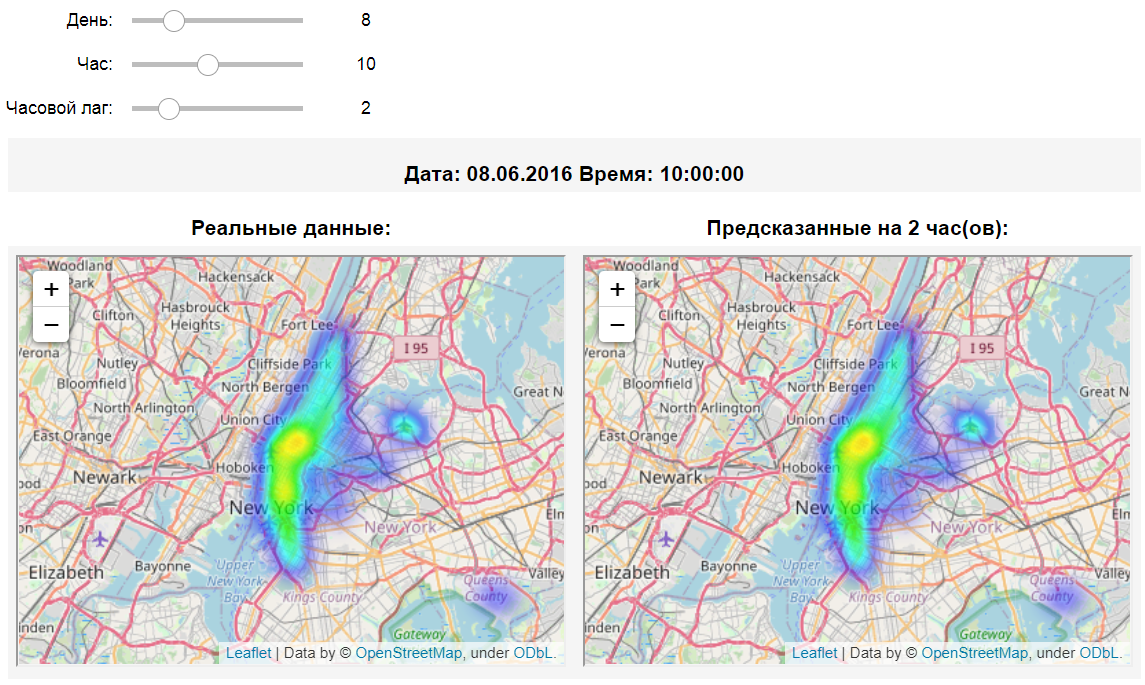

In [14]:
# При выводе в PDF ноутбука, графики, увы, не отображаются, посему выводим здесь также скриншот исполняемых графиков
Image("Data/Fig1_TaxiW7.PNG")

### 2. Временной ряд фактического и прогнозируемого спроса на такси в выбираемой области.

In [ ]:
# Судя по интерактиву выше, предсказания с любого временного лага (1...6) мало различимы, 
# так что для простоты оставим ниже предсказание с первого часа 
# (последние 5 часов июня в любом случае со 2-го по 6-й)

In [9]:
# добавляем метки всех 102 регионов (центры регионов) на карту
for reg, latt, long in zip(regions['region'], regions['latt'], regions['long']):
    text = u'Регион №' + str(reg)
    folium.Marker([latt, long], popup=text).add_to(map)

In [10]:
# отрисовываем карту, на которой пользователь может понять номер региона, 
# для которого он захочет вывести временной ряд
map

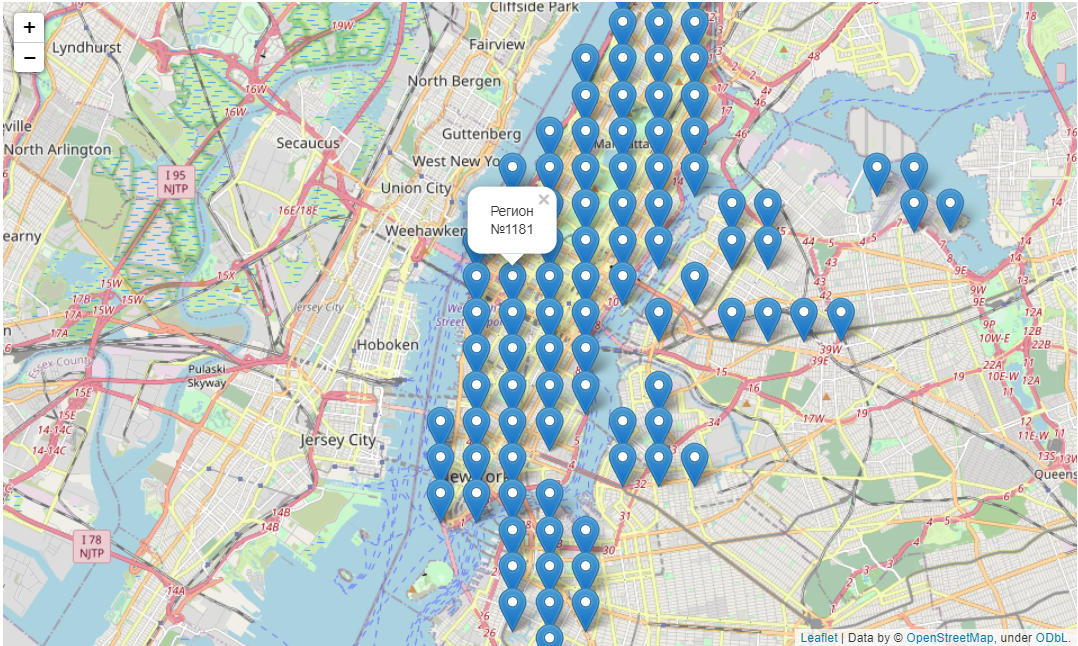

In [15]:
# При выводе в PDF ноутбука, графики, увы, не отображаются, посему выводим здесь также скриншот исполняемых графиков
Image("Data/Fig2_TaxiW7.PNG")

In [11]:
def PlotTimeSeries(reg):
    # реальные поездки из региона
    subdata = data[data.zone == reg]
    # конструктор предсказанных поездок из региона:
    # берем часовые предсказания y1 вплоть до 30.06.2016 18:00, и на оставшиеся часы y2,y3,y4,y5,y6
    subdata_pred = dataPred[dataPred.region == reg]
    sub1 = list(subdata_pred.y1)
    sub2 = [subdata_pred.iloc[subdata_pred.shape[0]-1].y2,subdata_pred.iloc[subdata_pred.shape[0]-1].y3,
        subdata_pred.iloc[subdata_pred.shape[0]-1].y4,subdata_pred.iloc[subdata_pred.shape[0]-1].y5,
        subdata_pred.iloc[subdata_pred.shape[0]-1].y6]
    subdata_pred = sub1 + sub2

    # Формируем входные параметры для построения графика
    x = range(subdata.shape[0])
    x_labels = subdata.index.tolist()
    y = list(subdata.num_trips)
    y_pred = list(subdata_pred)

    # Формируем метки и оформление для графика
    ticks = range(0, len(x), 12)
    x_ticks = [x[i] for i in ticks] + [x[len(x)-1]]
    x_labels_ticks = [x_labels[i] for i in ticks] + [x_labels[len(x_labels)-1]]
    f, (ax1) = plt.subplots(figsize=(20,10))
    ax1.set(title='Поездки в июне', xlabel='Час выезда', ylabel='Кол-во поездок')
    pl_real = ax1.plot(x, y, label='Реальные данные')
    pl_forecast = ax1.plot(x, y_pred, 'g', label='Предсказания')
    plt.xticks(x_ticks, x_labels_ticks, rotation='vertical')
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)
    plt.show()
    
def VisualizeSeries(reg):
    if len(reg)>0:
        r = reg[0]
        PlotTimeSeries(r)

In [12]:
TimeSer = interactive(VisualizeSeries, reg=widgets.SelectMultiple(
    options=reg_list, description=u'Выберите регион:', disabled=False))
display(TimeSer)

interactive(children=(SelectMultiple(description='Выберите регион:', options=(1075, 1076, 1077, 1125, 1126, 11…

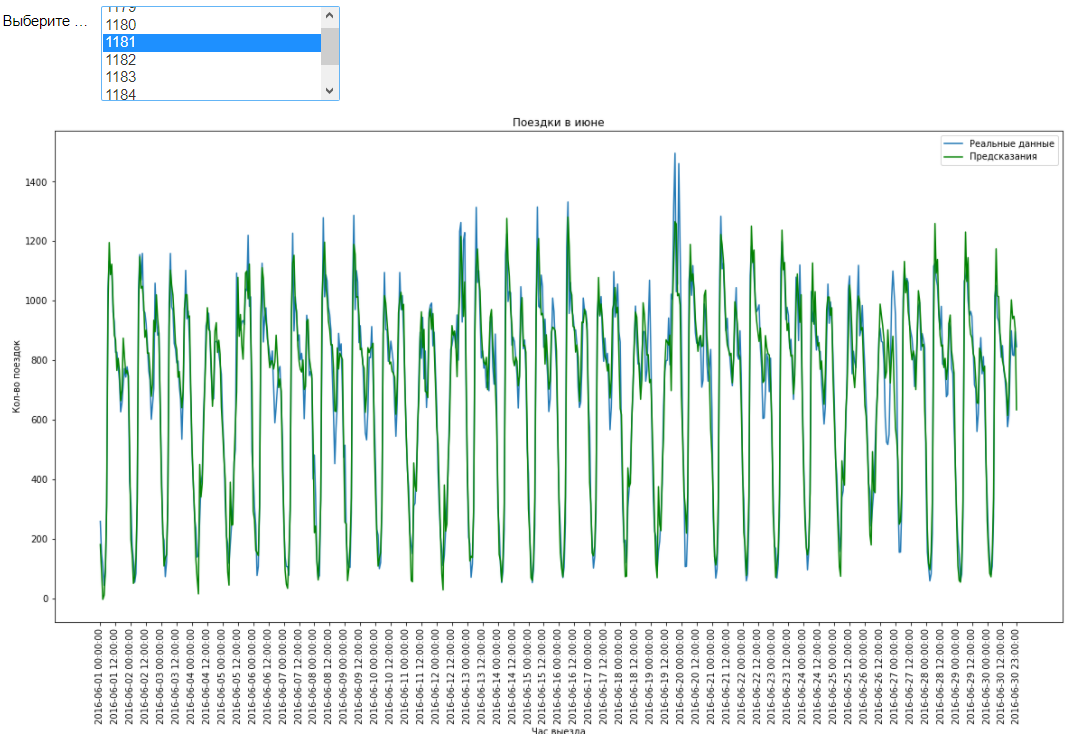

In [16]:
# При выводе в PDF ноутбука, графики, увы, не отображаются, посему выводим здесь также скриншот исполняемых графиков
Image("Data/Fig3_TaxiW7.PNG")